In [1]:
# This code cell imports stuff, etc.
import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns
import warnings


# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSimWithNoise

# Time duration and step size of sim in ms
T = 32000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)
Tburn=1000
Nburn=int(Tburn/dt)

# Number of E and I neurons in network
Ne = 4000
Ni = 1000
Ns=[Ne,Ni]
N = Ne+Ni


sigmav=1.0

# 2x2 matrices of connection probabilities and syn weights between
# exc and inh neurons: [[ee,ei],[ie,ii]]
p0=0.1
P = p0+np.zeros((2,2))
Jm = 0.5*np.array([[25.0,-150.0],[112.5,-250.0]])/np.sqrt(N)

# Exc and inh synaptic time constants in ms
tau=np.array([8.0,4.0])


# EIF Neuron parameters
NeuronParams = dict()
NeuronParams['Cm']=1.0
NeuronParams['gL']=1/15.0
NeuronParams['EL']=-72.0
NeuronParams['Vth']=0.0
NeuronParams['Vre']=-75.0
NeuronParams['Vlb']=-100.0
NeuronParams['DeltaT']=1.0
NeuronParams['VT']=-55.0


# Mean-field variables for estimating rates
# using balance approx
Q=np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)
Xmf = 0.6*np.array([.04,.02])

# Baseline external input to each neuron
X0 = Xmf*np.sqrt(N)

# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf
print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Stimulus params
StimDim = 10 # number of stim dimensions
taustim = 25.0 # timescale of stim variability
sigmastim = X0.mean()/15.0 # strength of stim input

# Number of trials to average over
numtrials=30

# Window size for count correlations
winsize=250

# Percent of conn matrix to re-wire for like-like
alpha=0.8


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
rBal =  9.882352941176466 22.588235294117638 Hz


In [2]:

# Get stimulus weight matrix
Jx=sigmastim*(np.random.randn(N,StimDim)+1.0)
Jx[Ne:,:]=0 

# Get random recurrent connectivity matrix
J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# Create re-wired Like-to-Like connectivity matrix.
# Re-wire a proportion alpha of connections to have
# connection probability proportional to covariance matrix 
# of inputs, ie, square of the input projection matrix.
Pe1=Jx[:Ne,:]@Jx[:Ne,:].T
Pe1=Pe1-Pe1.min()
Pe1=Pe1-Pe1*np.eye(Ne)
Pe1 = Pe1*(alpha*p0/Pe1.mean())
Pe1[Pe1<0]=0
MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))
JLikeLike=J.copy()
JLikeLike[:Ne,:Ne]=MaskEE*JLikeLike[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)


maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,winsize)
reRand = np.zeros((numtrials,Ne,len(RateTime)))
riRand = np.zeros((numtrials,Ni,len(RateTime)))
reLikeLike = np.zeros((numtrials,Ne,len(RateTime)))
riLikeLike = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for iii in range(numtrials):

        # Run random connectivity sim
        se,si,VeRec = EIFNetworkSimWithNoise(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord,sigmav)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reRand[iii,:,:] = GetSpikeCounts(se,winsize,Ne,T)/winsize
        riRand[iii,:,:] = GetSpikeCounts(si,winsize,Ni,T)/winsize
        print(iii+1,'of',numtrials,'rSimRand =',1000*reRand[iii,:,:].mean(),1000*riRand[iii,:,:].mean(),'Hz. ',tm()-t0,'s')
        
        # Run like-like sims.
        se,si,VeRec = EIFNetworkSimWithNoise(JLikeLike,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord,sigmav)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        reLikeLike[iii,:,:] = GetSpikeCounts(se,winsize,Ne,T)/winsize
        riLikeLike[iii,:,:] = GetSpikeCounts(si,winsize,Ni,T)/winsize
        print(iii+1,'of',numtrials,'rSimLikeLike =',1000*reLikeLike[iii,:,:].mean(),1000*riLikeLike[iii,:,:].mean(),'Hz. ',tm()-t0,'s')

print('Sims complete.')        

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1 of 30 rSimRand = 8.048757812500002 15.047906250000002 Hz.  117.41452527046204 s
1 of 30 rSimLikeLike = 8.250304687500003 15.401093750000005 Hz.  238.68513202667236 s
2 of 30 rSimRand = 8.0478828125 15.048281250000002 Hz.  359.2819082736969 s
2 of 30 rSimLikeLike = 8.252937499999998 15.405531250000003 Hz.  480.7453510761261 s
3 of 30 rSimRand = 8.050265625 15.049500000000004 Hz.  601.4052243232727 s
3 of 30 rSimLikeLike = 8.246625 15.397406250000005 Hz.  723.030189037323 s
4 of 30 rSimRand = 8.046218750000001 15.045250000000001 Hz.  844.2024700641632 s
4 of 30 rSimLikeLike = 8.248648437499996 15.402718750000002 Hz.  965.8867211341858 s
5 of 30 rSimRand = 8.047570312500001 15.04646875 Hz.  1087.4463572502136 s
5 of 30 rSimLikeLike = 8.24927

In [1]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

# Cutoff firing rate to use each neuron in the analysis
rmin=1.0/1000

# Number of trials over which to apply analysis
nt=numtrials

# Bin sizes for correlation histograms
dBins=0.02
CorrBins=np.arange(-1,1+dBins,dBins)

##############
### First do analysis for sims with random connectivity 

# Spike counts from rates with burn-in
ECounts = winsize*reRand[:nt,:,int(Tburn/winsize):-int(Tburn/winsize)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)

# Cut off neurons below rate threshold
ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')

# Correlation matrix of Exc neurons included in analysis
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

# Connection matrix between Exc neurons included in analysis
Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]

# Collect all correlation values for connected, unconnected neurons
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]

# Compute rates and variances of correlations in each pop
mAllEECorrsRand=AllEECorrs.mean()
mConnectedEECorrsRand=ConnectedEECorrs.mean()
mUnconnectedEECorrsRand=UnconnectedEECorrs.mean()
vAllEECorrsRand=AllEECorrs.var()
vConnectedEECorrsRand=ConnectedEECorrs.var()
vUnconnectedEECorrsRand=UnconnectedEECorrs.var()


print('Mean EE corr:',mAllEECorrsRand)
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',mConnectedEECorrsRand)
print('Mean unconnected EE corr:',mUnconnectedEECorrsRand)

# Bin the connection probabilities and compute connection prob in each bin
StimCorrBins = np.array([-1,-.5,-.25,0.0,.25,.5,.75,1.0])
ConnProbAtStimCorrRand=np.zeros(len(StimCorrBins)-1)
for i in range(1,len(StimCorrBins)):
    I1,I2=np.where(np.logical_and(CutoffEECorrMatrix>StimCorrBins[i-1],CutoffEECorrMatrix<=StimCorrBins[i]))
    I11=I1[I1>I2]
    I22=I2[I1>I2]
    ConnProbAtStimCorrRand[i-1]=(JeeCutoff[I11,I22]!=0).mean()

# Make plots
plt.figure(figsize=(5,3))
plt.plot(StimCorrBins[1:],ConnProbAtStimCorrRand/p0,'-o')
plt.axhline(y = 1, color = 'k', linestyle = '--')
plt.title('Random Connectivity', weight='bold')
plt.xlabel('signal correlation')
plt.ylabel('fold change of connection probability')
sns.despine()


hAllEERand,_=np.histogram(AllEECorrs,CorrBins,density=True)
hConnEERand,_=np.histogram(ConnectedEECorrs,CorrBins,density=True)
hUnconnEERand,_=np.histogram(UnconnectedEECorrs,CorrBins,density=True)

plt.figure(figsize=(6,3))
plt.plot(CorrBins[1:],hAllEERand, label="all: mean corr={:.3f}".format(mAllEECorrsRand))
plt.plot(CorrBins[1:],hConnEERand, label="connected: mean corr={:.3f}".format(mConnectedEECorrsRand))
plt.plot(CorrBins[1:],hUnconnEERand, label="unconnected: mean corr={:.3f}".format(mUnconnectedEECorrsRand))
plt.ylabel('density')
plt.xlabel('signal correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()


##################
### Now do the same analysis for sims with like-like connectivity 

# Counts from rates with burn-in
ECounts = winsize*reLikeLike[:nt,:,int(Tburn/winsize):-int(Tburn/winsize)]

# Average over trials
ECounts = ECounts[:nt,:,:].mean(axis=0)


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

Jee=JLikeLike[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


StimCorrBins = np.array([-1,-.5,-.25,0.0,.25,.5,.75,1.0])
ConnProbAtStimCorrLikeLike=np.zeros(len(StimCorrBins)-1)
for i in range(1,len(StimCorrBins)):
    I1,I2=np.where(np.logical_and(CutoffEECorrMatrix>StimCorrBins[i-1],CutoffEECorrMatrix<=StimCorrBins[i]))
    I11=I1[I1>I2]
    I22=I2[I1>I2]
    ConnProbAtStimCorrLikeLike[i-1]=(JeeCutoff[I11,I22]!=0).mean()

plt.figure(figsize=(5,3))
plt.plot(StimCorrBins[1:],ConnProbAtStimCorrLikeLike/p0,'-o')
plt.axhline(y = 1, color = 'k', linestyle = '--')
plt.title('Like-to-Like Connectivity', weight='bold')
plt.xlabel('signal correlation')
plt.ylabel('fold change of connection probability')
sns.despine()


print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())
print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())

hAllEELikeLike,_=np.histogram(AllEECorrs,CorrBins,density=True)
hConnEELikeLike,_=np.histogram(ConnectedEECorrs,CorrBins,density=True)
hUnconnEELikeLike,_=np.histogram(UnconnectedEECorrs,CorrBins,density=True)

mAllEECorrsLikeLike=AllEECorrs.mean()
mConnectedEECorrsLikeLike=ConnectedEECorrs.mean()
mUnconnectedEECorrsLikeLike=UnconnectedEECorrs.mean()

vAllEECorrsLikeLike=AllEECorrs.var()
vConnectedEECorrsLikeLike=ConnectedEECorrs.var()
vUnconnectedEECorrsLikeLike=UnconnectedEECorrs.var()


plt.figure(figsize=(6,3))
plt.plot(CorrBins[1:],hAllEELikeLike, label="all: mean corr={:.3f}".format(mAllEECorrsLikeLike))
plt.plot(CorrBins[1:],hConnEELikeLike, label="connected: mean corr={:.3f}".format(mConnectedEECorrsLikeLike))
plt.plot(CorrBins[1:],hUnconnEELikeLike, label="unconnected: mean corr={:.3f}".format(mUnconnectedEECorrsLikeLike))
plt.ylabel('density')
plt.xlabel('signal correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Like-to-Like Connectivity', weight='bold')
plt.yticks([])
sns.despine()
plt.tight_layout()





NameError: name 'sns' is not defined

In [4]:
# Save data that generates plots.

mAllEECorrs=AllEECorrs.mean()
mConnectedEECorrs=ConnectedEECorrs.mean()
mUnconnectedEECorrs=UnconnectedEECorrs.mean()

import pickle
filename='./Data/RandAndLikeLikeHists.npy'


objects = dict()

objects['hAllEERand']=hAllEERand
objects['hConnEERand']=hConnEERand
objects['hUnconnEERand']=hUnconnEERand
objects['hAllEELikeLike']=hAllEELikeLike
objects['hConnEELikeLike']=hConnEELikeLike
objects['hUnconnEELikeLike']=hUnconnEELikeLike

objects['CorrBins']=CorrBins

objects['mAllEECorrsRand']=mAllEECorrsRand
objects['mConnectedEECorrsRand']=mConnectedEECorrsRand
objects['mUnconnectedEECorrsRand']=mUnconnectedEECorrsRand

objects['vAllEECorrsRand']=vAllEECorrsRand
objects['vConnectedEECorrsRand']=vConnectedEECorrsRand
objects['vUnconnectedEECorrsRand']=vUnconnectedEECorrsRand

objects['mAllEECorrsLikeLike']=mAllEECorrsLikeLike
objects['mConnectedEECorrsLikeLike']=mConnectedEECorrsLikeLike
objects['mUnconnectedEECorrsLikeLike']=mUnconnectedEECorrsLikeLike

objects['vAllEECorrsLikeLike']=vAllEECorrsLikeLike
objects['vConnectedEECorrsLikeLike']=vConnectedEECorrsLikeLike
objects['vUnconnectedEECorrsLikeLike']=vUnconnectedEECorrsLikeLike

objects['ConnProbAtStimCorrRand']=ConnProbAtStimCorrRand
objects['ConnProbAtStimCorrLikeLike']=ConnProbAtStimCorrLikeLike
objects['StimCorrBins']=StimCorrBins


with open(filename, 'wb') as f:
    pickle.dump(objects, f)



In [5]:
# Save connectivity matrices and firing rates

import pickle
filename='./Data/ConnectivityAndRates.npy'

EEConnectivityRand = (J[:Ne,:Ne]!=0)
EEConnectivityLikeLike = (JLikeLike[:Ne,:Ne]!=0)

ERatesRand = reRand[:,:,int(Tburn/winsize):-int(Tburn/winsize)].mean(axis=0)
ERatesLikeLike = reLikeLike[:,:,int(Tburn/winsize):-int(Tburn/winsize)].mean(axis=0)

objects = dict()
objects['EEConnectivityRand']=EEConnectivityRand
objects['EEConnectivityLikeLike']=EEConnectivityLikeLike
objects['ERatesRand']=ERatesRand
objects['ERatesLikeLikev']=ERatesLikeLike

with open(filename, 'wb') as f:
    pickle.dump(objects, f)

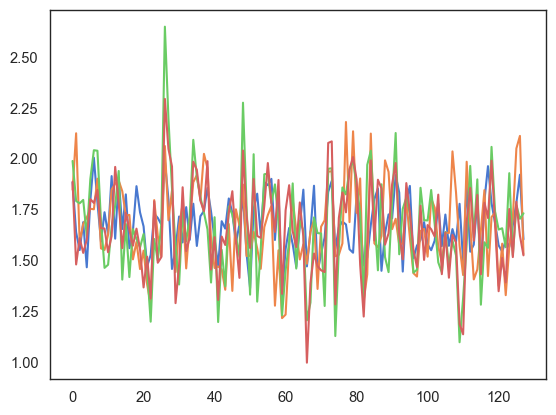

In [6]:
# # Get stimulus weights
# Jx=sigmastim*(0.2*np.random.randn(N,StimDim)+.2)
# Jx[Ne:,:]=0

# # Get random recurrent connectivity matrix
# J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# # Create re-wired Like-to-Like connectivity matrix
# Pe1=Jx[:Ne,:]@Jx[:Ne,:].T
# Pe1=Pe1-Pe1.min()
# Pe1=Pe1-Pe1*np.eye(Ne)
# Pe1 = Pe1*(alpha*p0/Pe1.mean())
# Pe1[Pe1<0]=0
# MaskEE=np.random.binomial(1,1.0-alpha,size=(Ne,Ne))
# JLikeLike=J.copy()
# JLikeLike[:Ne,:Ne]=MaskEE*JLikeLike[:Ne,:Ne]+Jm[0,0]*np.random.binomial(1,Pe1,size=(Ne,Ne))

# # External input on top of baseline
# X=np.zeros((StimDim,Nt))
# for j in range(StimDim):
#   X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)



# Compute input correlations
Xcoarse = X.reshape((StimDim,-1,int(winsize/dt))).mean(axis=2)
IEXcoarse=Jx[:Ne,:]@Xcoarse

# Plot some inputs
plt.plot(IEXcoarse[:4,:].T+X0[0])

In [7]:
print(T)

32000
